<a href="https://colab.research.google.com/github/D-2000-99/Tensorflow-Object-Detection/blob/main/SSD_TFOD_Custom_(Guitar).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

This project is an attempt at detecting guitars in a given image from a model I custom trained with my code [here](https://colab.research.google.com/github/D-2000-99/Tensorflow-Object-Detection/blob/main/Tensorflow_Custom_Object_Detection_on_Colab_.ipynb). 

Skip to the end for results ->
[Link](#fin)

## Clone Tensorflow Models Repository

In [ ]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 68232, done.
remote: Total 68232 (delta 0), reused 0 (delta 0), pack-reused 68232
Receiving objects: 100% (68232/68232), 576.51 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (47944/47944), done.


##Protobuf

In [ ]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

## Object detection API

In [ ]:
!cd models/research && \
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.8 MB 8.0 MB/s 
     |████████████████████████████████| 352 kB 52.5 MB/s 
     |████████████████████████████████| 1.8 MB 40.2 MB/s 
     |████████████████████████████████| 23.1 MB 1.7 MB/s 
     |████████████████████████████████| 47.6 MB 74 kB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.2 MB 52.1 MB/s 
     |████████████████████████████████| 213 kB 50.1 MB/s 
     |████████████████████████████████| 596 kB 56.4 

## Import Libraries

In [ ]:
import os
import pathlib
import time

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Enable GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Mounting drive to access custom model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DL_models/TFOD_guitar/final_model.zip -d /content/mod

Archive:  /content/drive/MyDrive/DL_models/TFOD_guitar/final_model.zip
   creating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/
   creating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model/
   creating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model/saved_model/
  inflating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model/saved_model/saved_model.pb  
   creating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model/saved_model/assets/
   creating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model/saved_model/variables/
  inflating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model/saved_model/variables/variables.index  
  inflating: /content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model/saved_model/variables/variables.data-00000-of-00001  
   cr

In [ ]:
PATH_TO_MODEL_DIR = '/content/mod/content/Tensorflow/workspace/training_demo/exported-models/my_model'

## Uploading Labels File

Uploading custom label_map.pbtext

In [ ]:
PATH_TO_LABELS = '/content/label_map.pbtxt'

In [ ]:
PATH_TO_LABELS

'/content/label_map.pbtxt'

In [ ]:
!head {PATH_TO_LABELS}

item {
    id: 1
    name: 'guitar'
}


## Loading in the custom model

In [ ]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 20.746854305267334 seconds


## Loading in the custom labels
We load in the custom label files and create the category_index required by TFOD

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS,
    use_display_name=True)

In [ ]:
category_index

{1: {'id': 1, 'name': 'guitar'}}

## Helper function

In [ ]:
## Helper function

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

## Object detection

In [ ]:
def detect_objects(image_path):
    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)

    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Do the detection
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # show classes
    # unique_classes = set(detections['detection_classes'])
    # print("Classes found:")
    # for c in unique_classes:
    #     print(category_index[c]['name'])

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure(figsize=(15, 10))
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

<a name="fin"></a>
# Final Results

Running inference for A02.jpg... Done


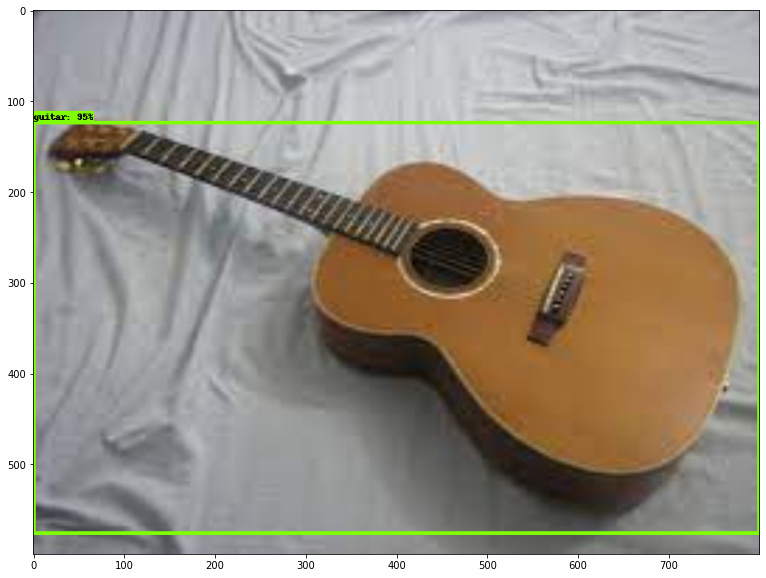

In [ ]:
detect_objects(IMAGE_PATHS[0])

Running inference for /content/bluegirlguitar.jpg... Done


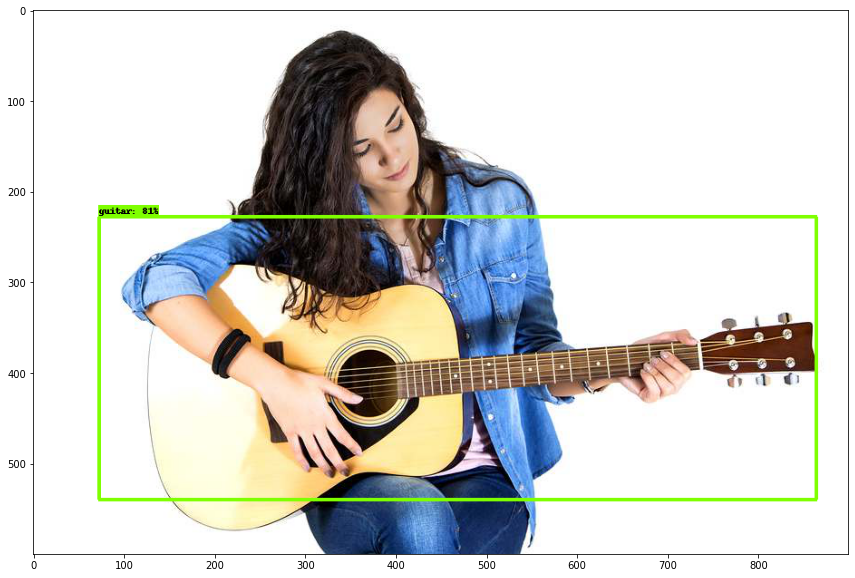

In [ ]:
detect_objects('/content/bluegirlguitar.jpg')

Running inference for /content/download.jpg... Done


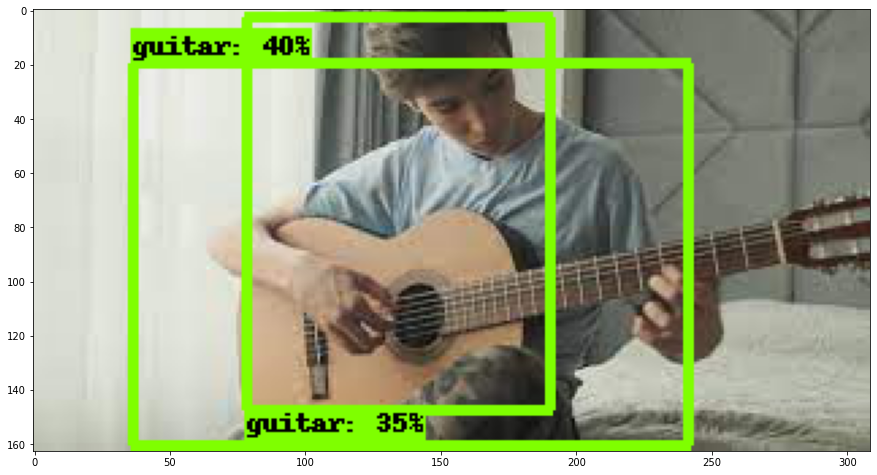

In [ ]:
detect_objects('/content/download.jpg')

Running inference for /content/photo-1568193755668-aae18714a9f1.jpg... Done


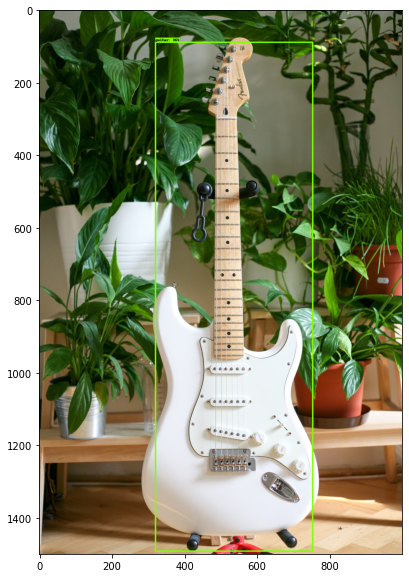

In [ ]:
detect_objects('/content/photo-1568193755668-aae18714a9f1.jpg')

Running inference for /content/314ce-324ce V-class 5050-black tuners.jpg... Done


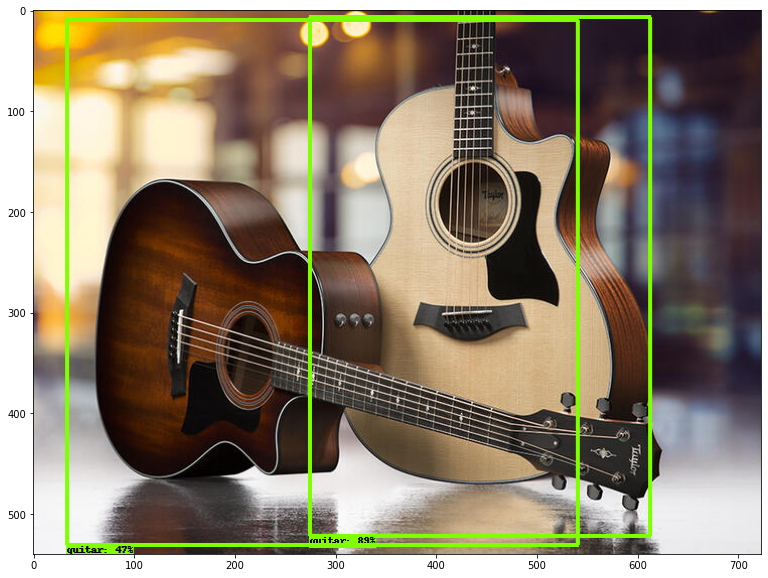

In [ ]:
detect_objects('/content/314ce-324ce V-class 5050-black tuners.jpg')

#Final notes:
We see that the model is able to draw bounding boxes but it blunders in a few images, this is because of the limited training of the model. Increasing batch size, number of training steps would definetely improve model performance and reduce loss.  